In [264]:
import pandas as pd
from pathlib import Path
import tensorflow as tf
from skmultilearn.model_selection import iterative_train_test_split
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt


In [265]:
df = Path("../histories").glob("mobilenetv2_1.00_224_filtered_multilabel*")
df = [pd.read_csv(csv) for csv in df] 
df = pd.concat(df)
df = df.drop_duplicates(["model", "epoch"], keep="last")
df

,binary_accuracy,f1_score_per_class,f1_score_weighted,loss,val_binary_accuracy,val_f1_score_per_class,val_f1_score_weighted,val_loss,model,epoch,type
0,0.939452,tf.Tensor(\n[0. 0.02298848 0.01503756 ...,0.326755,0.178081,0.968450,tf.Tensor(\n[0. 0. 0.08695652 ...,0.405542,0.106811,mobilenetv2_1.00_224_filtered_multilabel,0,CLF
1,0.970459,tf.Tensor(\n[0. 0. 0.14634144 ...,0.460955,0.097633,0.971706,tf.Tensor(\n[0. 0. 0.08695652 ...,0.490033,0.086371,mobilenetv2_1.00_224_filtered_multilabel,1,CLF
2,0.973165,tf.Tensor(\n[0. 0.01324503 0.31818175 ...,0.524442,0.082583,0.973643,tf.Tensor(\n[0. 0. 0.2222222 ...,0.535161,0.077014,mobilenetv2_1.00_224_filtered_multilabel,2,CLF
3,0.975028,tf.Tensor(\n[0. 0.01333333 0.45180717 ...,0.564923,0.073512,0.975349,tf.Tensor(\n[0. 0. 0.2222222 ...,0.570628,0.070680,mobilenetv2_1.00_224_filtered_multilabel,3,CLF
4,0.976348,tf.Tensor(\n[0. 0.04999998 0.48520705 ...,0.598324,0.067484,0.976357,tf.Tensor(\n[0. 0. 0.28571424 ...,0.595100,0.066293,mobilenetv2_1.00_224_filtered_multilabel,4,CLF
5,0.977705,tf.Tensor(\n[0. 0.10843372 0.52753615 ...,0.630182,0.062001,0.977442,tf.Tensor(\n[0. 0. 0.39999998 ...,0.615522,0.062788,mobilenetv2_1.00_224_filtered_multilabel,5,CLF
6,0.978549,tf.Tensor(\n[0. 0.18604647 0.55932194 ...,0.650010,0.058831,0.978295,tf.Tensor(\n[0. 0.07692306 0.45161283 ...,0.632189,0.060363,mobilenetv2_1.00_224_filtered_multilabel,6,CLF
7,0.979548,tf.Tensor(\n[0. 0.30337074 0.57617724 ...,0.674393,0.054940,0.978837,tf.Tensor(\n[0. 0.14814812 0.51612896 ...,0.644653,0.058310,mobilenetv2_1.00_224_filtered_multilabel,7,CLF
8,0.980120,tf.Tensor(\n[0. 0.31521735 0.6239999 ...,0.690645,0.052350,0.978992,tf.Tensor(\n[0. 0.21428569 0.5454545 ...,0.653462,0.056387,mobilenetv2_1.00_224_filtered_multilabel,8,CLF
9,0.980974,tf.Tensor(\n[0. 0.29189187 0.60752684 ...,0.707402,0.050046,0.980000,tf.Tensor(\n[0. 0.2222222 0.6285714 ...,0.673565,0.054920,mobilenetv2_1.00_224_filtered_multilabel,9,CLF


# Dataset

In [266]:
image_dir = "/home/ruairi/.cache/kagglehub/datasets/bloox2/fieldplant/versions/1/train/"

In [267]:
def decode_img(filename, img_size):
    filepath = str(image_dir) + filename
    img = tf.io.read_file(filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    return img

def process_dataset(img, label):
    img = decode_img(img, (224,224))
    return img, label

In [268]:
df = pd.read_csv("../data/filtered.csv")

X = df.filename.to_frame().to_numpy()
y = df.drop(columns=["filename"]).to_numpy()

X_train, y_train, X_test_val, y_test_val = iterative_train_test_split(X, y, test_size=0.2)
X_test, y_test, X_val, y_val = iterative_train_test_split(X_test_val, y_test_val, test_size=0.5)

train = pd.DataFrame(np.hstack([X_train, y_train]))
val = pd.DataFrame(np.hstack([X_val, y_val]))
test = pd.DataFrame(np.hstack([X_test, y_test]))

train.columns = df.columns
test.columns = df.columns
val.columns = df.columns


In [269]:
BATCH_SIZE=64

In [270]:
X_train = train["filename"].values.astype(str)
y_train = train.drop(columns="filename").values.astype("float32")
X_test = test["filename"].values.astype(str)
y_test = test.drop(columns="filename").values.astype("float32")
X_val = val["filename"].values.astype(str)
y_val = val.drop(columns="filename").values.astype("float32")

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

train_ds = train_ds.map(lambda img, label: process_dataset(img, label)).shuffle(buffer_size=train_ds.cardinality()).batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda img, label: process_dataset(img, label)).batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda img, label: process_dataset(img, label)).batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)



# Model

In [271]:
num_classes = len(df.columns[1:])

In [272]:
epochs = 100

In [223]:
preprocessing = tf.keras.applications.mobilenet_v2.preprocess_input
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocessing(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="sigmoid")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics = [
        "binary_accuracy",
        tf.keras.metrics.F1Score(average="weighted", threshold=0.5, name="f1_score_weighted", dtype=None),
        tf.keras.metrics.F1Score(average=None, threshold=0.5, name="f1_score_per_class", dtype=None)
    ]
)

cbs = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath="../saved_models/final_mn.keras", save_best_only=True, monitor="val_loss", verbose=1)
]

model.summary(show_trainable=True, expand_nested=True)

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_51 (InputLayer) │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ true_divide_23 (TrueDivide) │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ subtract_23 (Subtract)      │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mobilenetv2_1.00_224        │ (None, 7, 7, 1280)    │  2,257,984 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ input_layer_50         │ (None, 224, 224, 3)   │          0 │   -   │
│ (InputLayer)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ Conv1 (Conv2D)         │ (None, 112, 112, 32)  │        864 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ bn_Conv1               │ (None, 112, 112, 32)  │        128 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ Conv1_relu (ReLU)      │ (None, 112, 112, 32)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 112, 112, 32)  │        288 │   N   │
│ expanded_conv_depthwise     │                       │            │       │
│ (DepthwiseConv2D)           │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 112, 112, 32)  │        128 │   N   │
│ expanded_conv_depthwise_BN  │                       │            │       │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 112, 112, 32)  │          0 │   -   │
│ expanded_conv_depthwise_re… │                       │            │       │
│ (ReLU)                      │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ expanded_conv_project  │ (None, 112, 112, 16)  │        512 │   N   │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 112, 112, 16)  │         64 │   N   │
│ expanded_conv_project_BN    │                       │            │       │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block_1_expand         │ (None, 112, 112, 96)  │      1,536 │   N   │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block_1_expand_BN      │ (None, 112, 112, 96)  │        384 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block_1_expand_relu    │ (None, 112, 112, 96)  │          0 │   -   │
│ (ReLU)                      │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block_1_pad            │ (None, 113, 113, 96)  │          0 │   -   │
│ (ZeroPadding2D)             │                       │            │     

 Total params: 2,290,009 (8.74 MB)

 Trainable params: 32,025 (125.10 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [224]:
# history = model.fit(train_ds, validation_data=val_ds,
#                     epochs=epochs, callbacks=cbs)

Epoch 1/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - binary_accuracy: 0.9261 - f1_score_per_class: 0.0878 - f1_score_weighted: 0.2924 - loss: 0.1948
Epoch 1: val_loss improved from inf to 0.08202, saving model to ../saved_models/final_mn.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - binary_accuracy: 0.9263 - f1_score_per_class: 0.0880 - f1_score_weighted: 0.2932 - loss: 0.1943 - val_binary_accuracy: 0.9697 - val_f1_score_per_class: 0.1265 - val_f1_score_weighted: 0.4701 - val_loss: 0.0820
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - binary_accuracy: 0.9720 - f1_score_per_class: 0.1896 - f1_score_weighted: 0.5495 - loss: 0.0794
Epoch 2: val_loss improved from 0.08202 to 0.07003, saving model to ../saved_models/final_mn.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - binary_accuracy: 0.9720 - f1_score_per_class: 0.1898 - f1_score_weighted: 0.5497 - loss: 0.0793 - val_binary_accuracy: 0.9736 - val_f1_score_per_class: 0.2283 - val_f1_score_weighted: 0.5678 - val_loss:

### Finetuning

In [225]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df['type'] = "CLF"

In [226]:
best_epoch = history_df.iloc[history_df.val_loss.idxmin()]
best_val_loss = best_epoch.val_loss
best_val_loss

np.float64(0.04895348101854324)

In [227]:
base_model = model.get_layer(name="mobilenetv2_1.00_224")
freeze_layer = base_model.get_layer(name="block_14_expand")
freeze_num = 0
for i, layer in enumerate(base_model.layers):
    if layer == freeze_layer:
        freeze_num = i

In [228]:
for layer in base_model.layers[:freeze_num]:
    layer.trainable = False
for layer in base_model.layers[freeze_num:]:
    layer.trainable = True

lr = model.get_compile_config()['optimizer']['config']['learning_rate'] / 10

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
    loss="binary_crossentropy",
    metrics = [
        "binary_accuracy",
        tf.keras.metrics.F1Score(average="weighted", threshold=0.5, name="f1_score_weighted", dtype=None),
        tf.keras.metrics.F1Score(average=None, threshold=0.5, name="f1_score_per_class", dtype=None)
    ]
)

cbs = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=1, baseline=best_val_loss),
    tf.keras.callbacks.ModelCheckpoint(filepath="../saved_models/final_mn.keras", save_best_only=True, monitor="val_loss", verbose=1, initial_value_threshold=best_val_loss)
]

model.summary(show_trainable=True, expand_nested=True)

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_51 (InputLayer) │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ true_divide_23 (TrueDivide) │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ subtract_23 (Subtract)      │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mobilenetv2_1.00_224        │ (None, 7, 7, 1280)    │  2,257,984 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ input_layer_50         │ (None, 224, 224, 3)   │          0 │   -   │
│ (InputLayer)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ Conv1 (Conv2D)         │ (None, 112, 112, 32)  │        864 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ bn_Conv1               │ (None, 112, 112, 32)  │        128 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ Conv1_relu (ReLU)      │ (None, 112, 112, 32)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 112, 112, 32)  │        288 │   N   │
│ expanded_conv_depthwise     │                       │            │       │
│ (DepthwiseConv2D)           │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 112, 112, 32)  │        128 │   N   │
│ expanded_conv_depthwise_BN  │                       │            │       │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 112, 112, 32)  │          0 │   -   │
│ expanded_conv_depthwise_re… │                       │            │       │
│ (ReLU)                      │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ expanded_conv_project  │ (None, 112, 112, 16)  │        512 │   N   │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 112, 112, 16)  │         64 │   N   │
│ expanded_conv_project_BN    │                       │            │       │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block_1_expand         │ (None, 112, 112, 96)  │      1,536 │   N   │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block_1_expand_BN      │ (None, 112, 112, 96)  │        384 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block_1_expand_relu    │ (None, 112, 112, 96)  │          0 │   -   │
│ (ReLU)                      │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block_1_pad            │ (None, 113, 113, 96)  │          0 │   -   │
│ (ZeroPadding2D)             │                       │            │     

 Total params: 2,290,009 (8.74 MB)

 Trainable params: 1,558,105 (5.94 MB)

 Non-trainable params: 731,904 (2.79 MB)

In [229]:
# history_ft = model.fit(train_ds, validation_data=val_ds,
#                     epochs=epochs, callbacks=cbs, initial_epoch=best_epoch.epoch+1)

Epoch 23/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - binary_accuracy: 0.9762 - f1_score_per_class: 0.4669 - f1_score_weighted: 0.6732 - loss: 0.0671
Epoch 23: val_loss did not improve from 0.04895
129/129 ━━━━━━━━━━━━━━━━━━━━ 26s 122ms/step - binary_accuracy: 0.9762 - f1_score_per_class: 0.4674 - f1_score_weighted: 0.6735 - loss: 0.0671 - val_binary_accuracy: 0.9782 - val_f1_score_per_class: 0.4549 - val_f1_score_weighted: 0.7233 - val_loss: 0.0669
Epoch 24/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - binary_accuracy: 0.9896 - f1_score_per_class: 0.7220 - f1_score_weighted: 0.8665 - loss: 0.0276
Epoch 24: val_loss did not improve from 0.04895
129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - binary_accuracy: 0.9896 - f1_score_per_class: 0.7223 - f1_score_weighted: 0.8664 - loss: 0.0276 - val_binary_accuracy: 0.9803 - val_f1_score_per_class: 0.4849 - val_f1_score_weighted: 0.7567 - val_loss: 0.0621
Epoch 25/100
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - binary_accuracy: 0.9939 - f1_sc

In [230]:
hist_ft_df = pd.DataFrame(history_ft.history)
hist_ft_df['epoch'] = history_ft.epoch
hist_ft_df['type'] = "FT"

In [231]:
hist_df = pd.concat([history_df, hist_ft_df])
hist_df = hist_df.drop_duplicates(subset=["epoch"], keep="last")

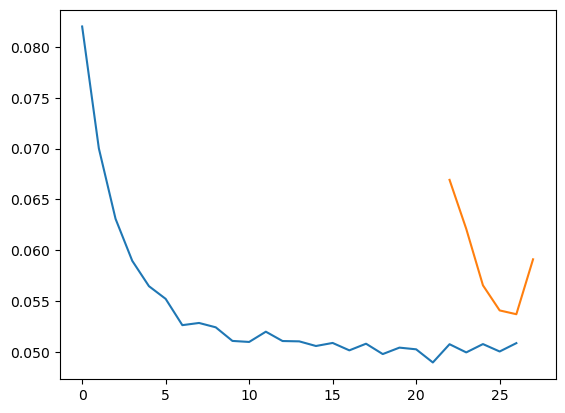

In [232]:
plt.plot(history_df.epoch, history_df.val_loss)
plt.plot(hist_ft_df.epoch, hist_ft_df.val_loss)

# Hyperparameter Tuning

In [273]:
def call_existing_code(units, dropout_rate):
    base_model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(224,224,3))
    base_model.trainable = False

    inputs = tf.keras.Input(shape=base_model.input_shape[1:])
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    if units != 0:
        x = tf.keras.layers.Dense(units=units, use_bias=False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Dropout(0.5)(x)

        
    outputs = tf.keras.layers.Dense(num_classes, activation="sigmoid", name="clasifier")(x)
    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss="binary_crossentropy",
        metrics=["binary_accuracy",
                 tf.keras.metrics.F1Score(average="weighted", threshold=0.5, name="f1_score_weighted", dtype=None),
                 tf.keras.metrics.F1Score(average=None, threshold=0.5, name="f1_score_per_class", dtype=None)]
        )
    return model

def build_model(hp):
    units = hp.Choice("units", [0, 256, 512])
    dropout_rate = hp.Choice("dropout", [0.2, 0.5])

    model = call_existing_code(
        units=units, dropout_rate=dropout_rate
    )
    return model

In [274]:
tuner = kt.RandomSearch(
    hypermodel= build_model,
    objective = kt.Objective("val_loss", "min"),
    directory="../hyperparameterTuning/",
    project_name="mobilenet_HT",
    overwrite=False,
    max_trials=40,
    seed=1
)
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Choice)
{'default': 0, 'conditions': [], 'values': [0, 256, 512], 'ordered': True}
dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.5], 'ordered': True}


In [ ]:
cbs = [tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=1)]

tuner.search(train_ds, validation_data=val_ds, epochs=epochs, callbacks=cbs, verbose=1)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
0                 |0                 |units
0.5               |0.5               |dropout

Epoch 1/100


In [ ]:
tuner.results_summary(32)